In [152]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #visualization
import warnings
warnings.filterwarnings("ignore")

In [172]:
df=pd.read_csv('dataset.csv')

In [173]:
#convert to numeric values , to find all missing values
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce') # convert into numerical feature
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [174]:
# correlation matrix between features, after all we can decide to delete missing values all entire column
df.SeniorCitizen=df.SeniorCitizen.astype('object') # changed dtype

In [175]:
df=df.fillna(df.TotalCharges.mean())# missing values replaced with mean value

In [176]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [177]:
#replace duplicate values
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

In [178]:
df.MultipleLines=df.MultipleLines.replace({'No phone service' : 'No'})

In [179]:
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})


In [180]:
df.Churn=df.Churn.replace({'Yes':1,'No':0})

In [181]:
#Grouping Numerical and Categorical dataset
# group the categorical columns together
cat_col = list(df.select_dtypes('object'))
num_col=list(df.select_dtypes({'int64', 'float64'}).columns.drop('Churn'))

In [182]:
print('Churn column values', '\n',(round(df.Churn.value_counts(normalize=True),3)*100))

Churn column values 
 0    73.5
1    26.5
Name: Churn, dtype: float64


In [117]:
#How do we select features?  Features are dropped when they do not contribute significantly to the model.

In [183]:
X, y = df.drop('Churn',axis=1), df[['Churn']]
## to find significant features using LassoCV (all X_scaled)

In [184]:
#Scaling Numerical Values between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [185]:
X[['tenure','TotalCharges','MonthlyCharges']] = scaler.fit_transform(X[['tenure','TotalCharges','MonthlyCharges']])

In [186]:
df_num=X[['tenure','TotalCharges','MonthlyCharges']]

,tenure,TotalCharges,MonthlyCharges
tenure,1.000000,0.824757,0.247900
TotalCharges,0.824757,1.000000,0.650468
MonthlyCharges,0.247900,0.650468,1.000000


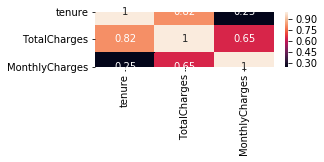

In [187]:
#correlation matrix-num_cols , seems TotalCharges and tenure have correlated. Features have big correlation
#does not give a lot of info. must delete one of them
corr = df_num.corr()
plt.figure(figsize=(4,1))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)
corr

In [188]:
X.drop(['tenure', 'customerID'], axis=1, inplace=True)

In [189]:
X.shape

(7043, 18)

In [197]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#categorical columns
cat_cols   = X.nunique()[X.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in y]
#Binary columns with 2 values
bin_cols= X.nunique()[X.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]
num_cols= [x for x in X.columns if x not in cat_cols]


#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    X[i] = le.fit_transform(X[i])

#Duplicating columns for multi value columns
X = pd.get_dummies(data = X,columns = multi_cols )


In [233]:
df_dummies=X

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score


In [214]:
X_train,y_train,X_test,y_test = train_test_split(df_dummies,y,test_size=0.2)


- I've decided to compare three  support vector machines with 3 different processes

#### Simple SVM algorithm, before tuning

In [215]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df_dummies, y, test_size=0.2, random_state=101)

In [216]:
from sklearn import svm
clf=svm.SVC()
svm_fit=clf.fit(X_train_s,y_train_s)
prediction_svm = clf.predict(X_test_s)
# Print the prediction accuracy
print (accuracy_score(y_test_s, prediction_svm))

0.78708303761533


In [217]:
roc_auc_score(y_test_s, prediction_svm)

0.6746255324996564

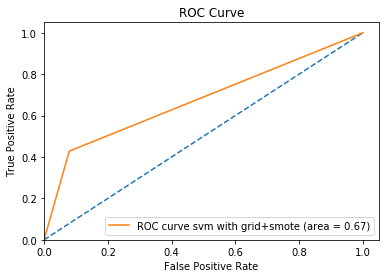

In [218]:
fpr, tpr, thresholds = roc_curve(y_test_s,prediction_svm)
#second fpr_1,tpr_1,thresholds_2
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='ROC curve svm with grid+smote (area = %0.2f)'%roc_auc_score(y_test_s, prediction_svm))

#plt.plot(fpr_1,tpr_1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0,1.05])
plt.ylim([0.0,1.05])
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Tuning SVM Parameters
###### GridSearchCV

In [236]:
from sklearn.model_selection import GridSearchCV

In [238]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(svm.SVC(), param_grid, cv=5,   refit = True, verbose = 3) 

In [239]:
grid.fit(X_train_s, y_train_s)
grid_svm = grid.predict(X_test_s) 
print(roc_auc_score(y_test_s, grid_svm))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.767, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.776, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.751, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.763, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.777, total=   1.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.786, total=   0.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.799, total=   0.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.783, total=   1.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.787, total=   0.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.807, total=   0.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.807, total=   0.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.783, total=   0.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.801, total=   0.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.794, total=   0.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.804, total=   0.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.796, total=   0.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.806, total=   0.9s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.795, total=   0.9s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.803, total=   0.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.801, total=   0.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.788, total=   0.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.806, total=   0.8s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.797, total=   0.8s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.8min finished


0.6968187439879071


In [245]:
print(accuracy_score(y_test_s, grid_svm))

0.7991483321504613


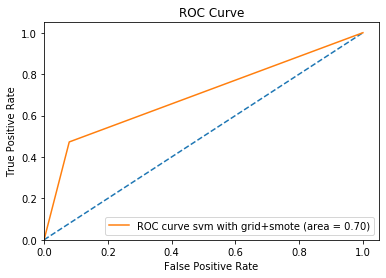

In [246]:
fpr, tpr, thresholds = roc_curve(y_test_s,grid_svm)
#second fpr_1,tpr_1,thresholds_2
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='ROC curve svm with grid+smote (area = %0.2f)'%roc_auc_score(y_test_s, grid_svm))

#plt.plot(fpr_1,tpr_1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0,1.05])
plt.ylim([0.0,1.05])
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### SMOTE

In [247]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42,ratio=1.0)
X_train_smote,y_train_smote=smote.fit_sample(X_train_s,y_train_s)
from collections import Counter
print('Before SMOTE:', Counter(y_train_s))
print('After SMOTE:', Counter(y_train_smote))

Before SMOTE: Counter({'Churn': 1})
After SMOTE: Counter({0: 4148, 1: 4148})


In [248]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=20)

In [249]:
grid.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.737, total=   2.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.731, total=   2.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.773, total=   2.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.794, total=   2.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.797, total=   2.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.763, total=   1.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.751, total=   1.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.742, total=   1.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.773, total=   1.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.774, total=   2.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.758, total=   1.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.751, total=   2.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.784, total=   2.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.756, total=   2.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.755, total=   2.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.742, total=   2.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.790, total=   2.4s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.764, total=   2.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.755, total=   2.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.742, total=   1.9s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.732, total=   2.2s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.758, total=   2.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.741, total=   2.2s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  5.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [250]:
grid_smote_svm = grid.predict(X_test_s) 
print(grid_smote_svm)

[0 1 1 ... 0 0 0]


In [251]:
accuracy_score(y_test_s,grid_smote_svm)

0.7310149041873669

In [252]:
roc_auc_score(y_test_s, grid_smote_svm)

0.6483988110688675

##### Random Under Sample 

In [253]:
from imblearn.under_sampling import RandomUnderSampler #decrease majority class, make same size with minority.

rus = RandomUnderSampler(random_state=42)

X_train_rus,y_train_rus=rus.fit_resample(X_train_s,y_train_s)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_train_rus, y_train_rus, test_size=0.2, random_state=20)

grid.fit(X_train_rus ,y_train_rus)

grid_rus_svm = grid.predict(X_test_s) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.701, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.689, total=   0.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.662, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.643, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.668, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.752, total=   0.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.763, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.731, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.721, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.768, total=   0.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.778, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.736, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.741, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.704, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.753, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.758, total=   0.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.741, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.704, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.768, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.779, total=   0.3s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.736, total=   0.3s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.741, total=   0.4s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.704, total=   0.4s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   49.2s finished


In [254]:
accuracy_score(y_test_s, grid_rus_svm)

0.7395315826827538

In [255]:
roc_auc_score(y_test_s, grid_rus_svm)

0.7548796563500426

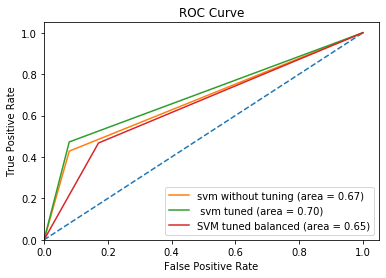

In [257]:
fpr, tpr, thresholds = roc_curve(y_test_s,prediction_svm)
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_s,grid_svm)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_s,grid_smote_svm)

#second fpr_1,tpr_1,thresholds_2
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='svm without tuning (area = %0.2f)'%roc_auc_score(y_test_s, prediction_svm))
plt.plot(fpr_1, tpr_1, label=' svm tuned (area = %0.2f)'%roc_auc_score(y_test_s, grid_svm))
plt.plot(fpr_2, tpr_2, label='SVM tuned balanced (area = %0.2f)'%roc_auc_score(y_test_s, grid_smote_svm))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0,1.05])
plt.ylim([0.0,1.05])
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()